In [1]:
import torch
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

from lookahead import Lookahead
import uncert
import pred
import prop

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the wine data

In [2]:
#load data
x,y0 = data = load_wine(return_X_y=True)
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose Ridge Regression with polynomial features (degree =2) as the groundtruth function f* and
select the best model using 5 - fold cross validation.

In [3]:
class Fstar():
    def __init__(self):
        self.model = RidgeCV(alphas=alpha_range)
    def fit(self, x, y):
        x2 = np.hstack([x, 0.5*x**2]).round(3)
        self.model.fit(x2, y)
    def predict(self, x):
        x2 = np.hstack([x, 0.5*x**2]).round(3)
        return self.model.predict(x2)

In [4]:
# Hyperparamters for the ground truth model
C_range = 2. ** np.arange(-8,10,2)
gamma_range = 2. ** np.arange(-10,3,2)
alpha_range = 2.**np.arange(-8,8)
param_grid = {'gamma':gamma_range, 'C':C_range}

# Train the model
fstar = Fstar()
fstar.fit(x, y0)
y = fstar.predict(x)
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

[f*] mse(y,y0): 0.04106275149850254
[f*] mae(y,y0): 0.16267291869162256


## Visualizing the features.
Features 0,1 have non-linaer relation to y

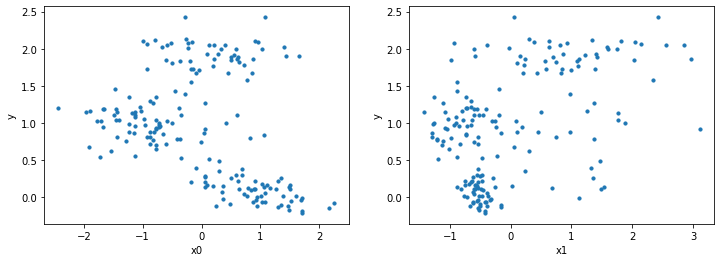

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)

plt.subplot(121)
plt.scatter(x[:,0], y, s=10)
plt.xlabel('x0')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x[:,1], y, s=10)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()


# np.corrcoef(x_trn[:,i],y_trn[:])[0,1]

In [6]:
# split data
trn_sz = 0.75
seed = 1

active = np.where(np.logical_and(x[:,0]>=-0.2,x[:,1]<=-0.3))[0]

x_active = x[active,:]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst = train_test_split(x_active, y_active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 178 , n_active: 57 , n_trn: 42 , n_tst: 15


## Setting the hyperparamters of the look ahead model

In [7]:
# Step Size
eta = 0.5 

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-4,2,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 0, 1, 4, 5, 7 and 8 are the only non-immutable features
mask = np.ones(d)

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.1
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20 
# Learning rate
lr_g = 0.1
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

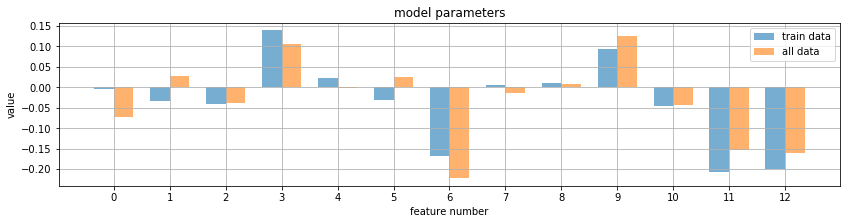

baseline: (skl)
		trn	tst	actv	all
mse	0.0557	0.0511	0.0544	0.0780
mae	0.1932	0.1750	0.1884	0.2229

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0557	0.0511	0.0544	0.0780
mae	0.1932	0.1750	0.1884	0.2229
imprv	0.1046	0.0303	0.0851	0.0851

best reg coef: 8.0 , idx: 12


In [8]:
# baselines
verbose = False

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type='l2', alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_init)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl/np.sum(np.abs(w_base_skl)),alpha=0.6,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench/np.sum(np.abs(w_bench)),alpha=0.6,width=barWidth)
plt.xticks(np.arange(d))
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Training the lookahead model for different values of lam

In [ ]:
# train our model
verbose = True

models = []
mfs = []
mus = []
for lam_ in lams:
    print('-- lam_:', lam_, '--')
    f = pred.PredModel(d, reg_type='none', alpha=0., lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
    u = uncert.BootstrapResid(d, f, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
    h = prop.PropModel(random_state=seed)

    model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
    mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)
    
    models.append(model)
    mfs.append(mf)
    mus.append(mu)
    
mus = np.asarray(mus)
mfs = np.asarray(mfs)

-- lam_: 1e-05 --
t: 0
[f] mse: 0.0431, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.161

t: 1
[h] n_eff: 28.56, w_sum: 31.54
[u] loss: 0.0670, norm_reg: 0.0000, obj: 0.0670
[u] size: 0.470, contain*: 0.738
[f] mse: 0.0431, la_reg: 0.0809, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.161

t: 2
[h] n_eff: 28.44, w_sum: 31.47
[u] loss: 0.0668, norm_reg: 0.0000, obj: 0.0668
[u] size: 0.470, contain*: 0.738
[f] mse: 0.0431, la_reg: 0.0808, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.161

t: 3
[h] n_eff: 28.35, w_sum: 31.40
[u] loss: 0.0667, norm_reg: 0.0000, obj: 0.0667
[u] size: 0.470, contain*: 0.738
[f] mse: 0.0431, la_reg: 0.0808, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.162

t: 4
[h] n_eff: 28.27, w_sum: 31.33
[u] loss: 0.0665, norm_reg: 0.0000, obj: 0.0665
[u] size: 0.470, contain*: 0.738
[f] mse: 0.0431, la_reg: 0.0807, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.162

t: 5
[h] n_eff: 28.21, w_sum: 31.28
[u] loss: 0.0664, norm_reg: 0.0000, obj: 0.0664
[u] s

[h] n_eff: 25.14, w_sum: 25.37
[u] loss: 0.0662, norm_reg: 0.0000, obj: 0.0662
[u] size: 0.540, contain*: 0.738
[f] mse: 0.0452, la_reg: 0.0742, norm_reg: 0.0000, obj: 0.0637
[f] improve*: 0.184

-- lam_: 0.5 --
t: 0
[f] mse: 0.0431, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0431
[f] improve*: 0.161

t: 1
[h] n_eff: 28.56, w_sum: 31.54
[u] loss: 0.0670, norm_reg: 0.0000, obj: 0.0670
[u] size: 0.470, contain*: 0.738
[f] mse: 0.0457, la_reg: 0.0625, norm_reg: 0.0000, obj: 0.0770
[f] improve*: 0.187

t: 2
[h] n_eff: 24.78, w_sum: 25.28
[u] loss: 0.0660, norm_reg: 0.0000, obj: 0.0660
[u] size: 0.547, contain*: 0.738
[f] mse: 0.0478, la_reg: 0.0678, norm_reg: 0.0000, obj: 0.0816
[f] improve*: 0.196

t: 3
[h] n_eff: 23.88, w_sum: 22.94
[u] loss: 0.0665, norm_reg: 0.0000, obj: 0.0665
[u] size: 0.581, contain*: 0.738
[f] mse: 0.0490, la_reg: 0.0698, norm_reg: 0.0000, obj: 0.0839
[f] improve*: 0.200

t: 4
[h] n_eff: 23.59, w_sum: 21.89
[u] loss: 0.0670, norm_reg: 0.0000, obj: 0.0670
[u] size: 0.

## Evaluating the performance of the trained lookahead models

In [ ]:
# evaluate

perf_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
for lam, model in zip(lams,models):
    perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

    xsp = [model.move_points(x_) for x_ in xs]
    perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
    perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}

print('lookahead: eta:', eta)
for i in range(len(lams)):
    print('\n==============================================\n')
    print('lam:', lams[i])
    print('\ttrn\tts\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_la['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_la['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_la['improve'][i,:]))
    print(('imprt'+'\t{:.4f}'*4).format(*perf_la['imprate'][i,:]))
    print()
    print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
    print(('contn'+'\t{:.3f}'*5).format(*perf_la['contain'][i,:]))
    print(('intrsz'+'\t{:.3f}'*5).format(*perf_la['size'][i,:]))

## Training the baseline model for different values of l2 - regularizer coefficient

In [ ]:
# train baseline model on all alphas

verbose = False

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type='l2', alpha=alpha, lr=lr_f, num_iter_init=num_iter_init)
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)
    
perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_base['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}    

## Training naive model and evaluate on multiple step size scales

In [ ]:
models_naive = []
scales = np.arange(1,1.16,0.01)
alpha_naive = 4.0

f_naive = pred.PredModel(d, reg_type='l2', alpha=alpha_naive, lr=lr_f, num_iter_init=num_iter_init)
model_naive = Lookahead(f_naive, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_naive.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
w_ = model_naive.f.model.state_dict()['linear.weight'].detach().numpy()

perf_naive = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for scale in scales:
    dict_ = OrderedDict({'linear.weight':torch.Tensor(w_*scale)})
    model_naive.f.model.load_state_dict(dict_, strict=False)
    models_naive.append(model_naive)
    perf_naive['mse'].append([model_naive.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_naive['mae'].append([model_naive.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_naive['improve'].append([model_naive.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_naive['imprate'].append([model_naive.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_naive = {k:np.asarray(v) for k,v in zip(perf_naive.keys(),perf_naive.values())}   

## Plotting the trade-off curve between mse and mean improvement for different settings

In [ ]:
# plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

SAVE_FIG = False
fname = 'wine_nomask_v3_rmse'

print('seed:',seed,', eta:',eta)

plt.rcParams['figure.figsize'] = (6.0, 4.0)

plt.plot(perf_base['improve'][:,0], perf_base['mse'][:,0],'b-x')
plt.plot(perf_la['improve'][:,0], perf_la['mse'][:,0],'r-x')
plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend(['base (alpha)','la (lambda)','naive (step size)'])
plt.grid()
plt.ylim([0.,0.18])
plt.xlim([0,0.3])
plt.show()

plt.plot(perf_base['improve'][:,1], np.sqrt(perf_base['mse'][:,1]),'-o',c='purple')
plt.plot(perf_la['improve'][:,1], np.sqrt(perf_la['mse'][:,1]),'-o',markerfacecolor='white')
plt.plot(perf_naive['improve'][:,1], np.sqrt(perf_naive['mse'][:,1]),'--',alpha=0.7)
plt.title('accuracy-improvement frontier (full mutability)')
plt.ylabel('RMSE [$(y-\hat{y})^2$]')
plt.xlabel('average improvement [$y\'-y$]')
plt.legend([r'baseline ($\lambda$=0, varying $\alpha$)',
            r'lookahead (varying $\lambda$, $\alpha$=0)',
            r'scaling ($\lambda$=0, optimal $\alpha$, varying $c$)'],
          loc='upper left')
plt.grid()
plt.ylim([0.2,0.5])
plt.xlim([0,0.14])

xx = perf_base['improve'][0,1]
yy =np.sqrt(perf_base['mse'][0,1])
plt.annotate(r'$\alpha$',
ha = 'center', va = 'bottom',
xytext = (xx-0.006,yy+0.012),
xy = (xx-0.022, yy),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
plt.annotate(r'$\lambda$',
ha = 'center', va = 'bottom',
xytext = (xx+0.008,yy+0.027),
xy = (xx+0.023, yy+0.08),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
xx2 = perf_base['improve'][-4,1]
yy2 = np.sqrt(perf_base['mse'][-4,1])
plt.annotate(r'$c$',
ha = 'center', va = 'bottom',
xytext = (xx2,yy2+0.02),
xy = (xx2+0.005, yy2+0.06),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)


ax = plt.gca() 
axins = inset_axes(ax, width="25%", height="25%", loc=4)
axins.plot(np.linspace(0,1,len(alphas)),perf_base['imprate'][:,1],'-o',markerfacecolor=None,c='purple',markersize=3)
axins.plot(np.linspace(0,1,len(lams)),perf_la['imprate'][:,1],'-o',markerfacecolor='white',markersize=3)
axins.set_xticks([])
axins.set_yticks([0.4,0.6, 1.0])
axins.yaxis.tick_right()
axins.set_xlim([0,1])
axins.set_ylabel('imp. rate')


if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

## Effect of varying the coefficient of look ahead regularizer

In [ ]:
ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(np.arange(len(lams))+0.5,ws_la[:,:2],'x-')
plt.plot(np.arange(len(lams))+0.5,ws_la[:,2:],'-')
plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,w_bench[i],'o')
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(0,-len(alphas),-1)-0.5,ws_base,'-.')
plt.legend([str(i) for i in range(d)])
plt.grid()
plt.ylim([-0.4,0.4])
plt.show()